# Метрики качества классификации

## 1. Данные

In [74]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X = pd.read_pickle('data/shelter/xtrain.pkl')
y = pd.read_csv('data/shelter/train.csv')['OutcomeType']

для учебных примеров оставим только 2 класса, отличающихся значительно и по смыслу, и по размеру

In [77]:
y.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [78]:
is_first_2_class = (y=='Adoption')|(y=='Euthanasia')

In [79]:
is_first_2_class

0        False
1         True
2         True
3        False
4        False
         ...  
26724    False
26725    False
26726     True
26727    False
26728    False
Name: OutcomeType, Length: 26729, dtype: bool

In [80]:
y

0        Return_to_owner
1             Euthanasia
2               Adoption
3               Transfer
4               Transfer
              ...       
26724           Transfer
26725           Transfer
26726           Adoption
26727           Transfer
26728           Transfer
Name: OutcomeType, Length: 26729, dtype: object

In [81]:
X = X[is_first_2_class]
X.index = range(len(X))
y = y[is_first_2_class]
y.index = range(len(y))

y теперь можно перевести в множество {0,1}

In [82]:
y = (y=='Adoption').astype(int)

для оценки качества разобьём выборки на 2 части, 3:1

In [83]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.25)

-----

## 2. Обучим классификатор

In [84]:
from sklearn.tree import DecisionTreeClassifier

In [85]:
clf = DecisionTreeClassifier(max_depth=5)

In [86]:
clf.fit(Xtr, ytr)

DecisionTreeClassifier(max_depth=5)

In [87]:
yval_pred = clf.predict(Xval)
yval_pred_proba = clf.predict_proba(Xval)

-----

## 3. Написание метрик с нуля

In [88]:
from sklearn import metrics

-----

In [89]:
metrics.confusion_matrix(yval, yval_pred)

array([[ 248,  156],
       [  22, 2655]])

In [90]:
metrics.accuracy_score(yval, yval_pred)

0.9422265498214866

In [91]:
metrics.precision_score(yval, yval_pred)

0.9445037353255069

In [92]:
metrics.recall_score(yval, yval_pred)

0.9917818453492716

In [93]:
metrics.roc_auc_score(yval, yval_pred_proba[:,1]) #сюда подаем только вероятнсоти принадлежности первому классу, нулевой не нужен

0.9349422288138415

In [94]:
metrics.average_precision_score(yval, yval_pred_proba[:,1])

0.984415913178139

## Реализовать самостоятельно вывод графика ROC-AUC

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

Задание 0:
======
Посчитать tpr и fpr в ноутбуке с лекции. Убедиться, что график ROC AUC получается таким же, как и штатными средствами

In [141]:
def calculate_tpr_and_fpr(y_true, y_pred_probas, alpha):
    ## 1. Отнесите  наблюдения к одному  из нескольких классов в зависимости от порога
    ## 2. Посчитайте tpr и fpr
    TP=0
    FP=0
    TN=0
    FN=0
    y_true = np.array(y_true)
    for i in range(0,len(y_true)):
        
        #прогноз
        if y_pred_probas[i] > alpha:
            prediction = 1
        else:
            prediction = 0
        
        # значения матрицы
        if (prediction == y_true[i]) & (prediction==1):
            TP += 1
        elif (prediction != y_true[i]) & (prediction==1):
            FP += 1 
        elif (prediction == y_true[i]) & (prediction==0):
            TN += 1     
        elif (prediction != y_true[i]) & (prediction==0):
            FN += 1     
    # метрики        
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    
    return tpr, fpr

In [142]:
def roc_auc_plot(y_true, y_pred_probas):
    alphas = np.arange(0, 1, 0.001)
    tprs, fprs = [], []
    for a in alphas:
        tpr, fpr = calculate_tpr_and_fpr(y_true, y_pred_probas, a)
        tprs.append(tpr)
        fprs.append(fpr)
        
    plt.plot(fprs, tprs)
    plt.show()

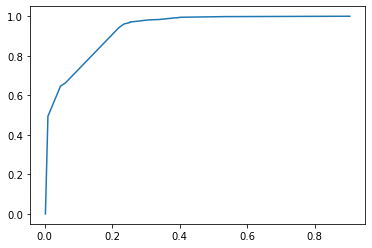

In [143]:
roc_auc_plot(yval, yval_pred_proba[:, 1])

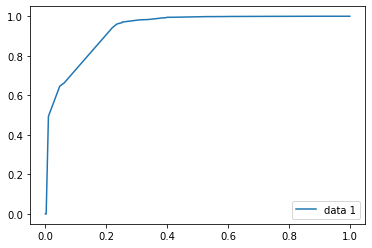

In [130]:
## SKLEARN
fpr, tpr, _ = metrics.roc_curve(yval,  yval_pred_proba[: ,1])
plt.plot(fpr,tpr,label="data 1")
plt.legend(loc=4)
plt.show()

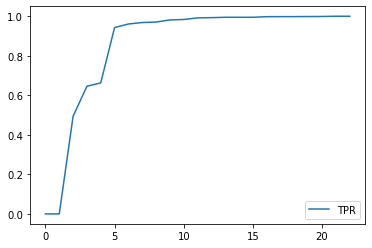

In [149]:
plt.plot(tpr,label="TPR")
plt.legend(loc=4)
plt.show()

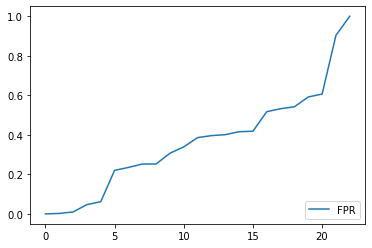

In [150]:
plt.plot(fpr,label="FPR")
plt.legend(loc=4)
plt.show()

In [153]:
tpr

array([0.        , 0.        , 0.49383638, 0.64587225, 0.66305566,
       0.94284647, 0.96077699, 0.96824804, 0.97048935, 0.98132238,
       0.98356369, 0.99178185, 0.9929025 , 0.99477027, 0.99477027,
       0.99477027, 0.99775869, 0.99813224, 0.99813224, 0.99850579,
       0.99887934, 1.        , 1.        ])

In [154]:
fpr

array([0.        , 0.00247525, 0.00990099, 0.0470297 , 0.06188119,
       0.22029703, 0.23514851, 0.25247525, 0.25247525, 0.30693069,
       0.33910891, 0.38613861, 0.3960396 , 0.4009901 , 0.41584158,
       0.41831683, 0.51732673, 0.53217822, 0.54207921, 0.59158416,
       0.60643564, 0.90346535, 1.        ])